# SpicePy: Observation Geometry for Space Science

---

[SPICEPy](http://github.com/AndrewAnnex/SpiceyPy) is a Python wrapper around the C-based [NAIF](http://naif.jpl.nasa.gov/naif/about.html) [SPICE](http://naif.jpl.nasa.gov/naif/spiceconcept.html) Toolkit which aids in computing observations from space-borne instruments.

Data file types used (kernels):
* FK - Frames Kernal for reference frames
* SCLK - Spacecraft Clock Kernel
* LSK - Leap Seconds Clock Kernel
* DSK - Digital Shape Model Kernel for irregularly/regularly shaped bodies

### Obtaining the Software

---

With Anaconda, one will need to run the following command in order to obtain SpiceyPy from the command line (after ensuring you are running Anaconda) or from the Anaconda Prompt:

```bash
conda config --add channels conda-forge
conda install spiceypy
```

__Note:__ You will need to restart the Jupyter Notebook or exit from the notebook server in order for the running environment to "see" the new package installed.

### Working through the Cassini Example

---

Due to unfamiliarty of this software, we are just going to step through the provided [online example](http://spiceypy.readthedocs.io/en/master/exampleone.html) to see the position of the spacecraft relative to the barycenter (COM between two bodies) of Saturn.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import spiceypy as spice

In [2]:
# Print out the toolkit version
spice.tkvrsn("TOOLKIT")

'CSPICE_N0066'

__Obtaining Anscillary Kernel Files__

In order to use SpicePy, we need to download some kernels that aid in the calculations. We can do this easily enough in Python as well.

In [9]:
import os
from requests import get

files = [
    'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/a_old_versions/naif0009.tls',
    'https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/sclk/cas00084.tsc',
    'https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/pck/cpck05Mar2004.tpc',
    'https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/fk/release.11/cas_v37.tf',
    'https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/ck/04135_04171pc_psiv2.bc',
    'https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/spk/030201AP_SK_SM546_T45.bsp',
    'https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/ik/release.11/cas_iss_v09.ti',
    'https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/spk/020514_SE_SAT105.bsp',
    'https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/spk/981005_PLTEPH-DE405S.bsp',
]

for url in files:
    file_name = os.path.join(os.getcwd(), url.split('/')[-1])
    with open(file_name, 'wb') as f:
        r = get(url)
        f.write(r.content)
    print('Download successful for ' + url)

Download successful for https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/a_old_versions/naif0009.tls
Download successful for https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/sclk/cas00084.tsc
Download successful for https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/pck/cpck05Mar2004.tpc
Download successful for https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/fk/release.11/cas_v37.tf
Download successful for https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/ck/04135_04171pc_psiv2.bc
Download successful for https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/spk/030201AP_SK_SM546_T45.bsp
Download successful for https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/ik/release.11/cas_iss_v09.ti
Download successful for https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/spk/020514_SE_SAT105.bsp
Download successful for https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/spk/981005_PLTEPH-DE405S.bsp


We also have to furnish a metakernel (ASCII file) containing the filenames that we downloaded. We can easily do that also in Python:

In [21]:
metakernel = os.path.join(os.getcwd(), 'cassMetaK.txt')

with open(metakernel, 'w') as f:
    f.write('''\\begindata
KERNELS_TO_LOAD=(\n''')

for url in files[:-1]:
    file_name = url.split('/')[-1]
    with open(metakernel, 'a') as f:
        f.write("\t'" + file_name + "',\n")

with open(metakernel, 'a') as f:
    f.write("\t'" + files[-1].split('/')[-1] + """')
\\begintext""")

In [22]:
spice.furnsh(metakernel)

In [23]:
step = 4000
# we are going to get positions between these two dates
utc = ['Jun 20, 2004', 'Dec 1, 2005']

# get et values one and two, we could vectorize str2et
etOne = spice.str2et(utc[0])
etTwo = spice.str2et(utc[1])
print("ET One: {}, ET Two: {}".format(etOne, etTwo))

ET One: 140961664.18440723, ET Two: 186667264.18308285


In [24]:
# get times
times = [x*(etTwo-etOne)/step + etOne for x in range(step)]

# check first few times:
print(times[0:3])

[140961664.18440723, 140973090.5844069, 140984516.98440656]


In [25]:
# check the documentation on spkpos before continueing
help(spice.spkpos)

Help on function spkpos in module spiceypy.spiceypy:

spkpos(targ, et, ref, abcorr, obs)
    Return the position of a target body relative to an observing
    body, optionally corrected for light time (planetary aberration)
    and stellar aberration.
    
    http://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/spkpos_c.html
    
    :param targ: Target body name.
    :type targ: str
    :param et: Observer epoch.
    :type et: Union[float,Iterable[float]]
    :param ref: Reference frame of output position vector.
    :type ref: str
    :param abcorr: Aberration correction flag.
    :type abcorr: str
    :param obs: Observing body name.
    :type obs: str
    :return:
            Position of target,
            One way light time between observer and target.
    :rtype: tuple



In [26]:
#Run spkpos as a vectorized function
positions, lightTimes = spice.spkpos('Cassini', times, 'J2000', 'NONE', 'SATURN BARYCENTER')

# Positions is a 3xN vector of XYZ positions
print("Positions: ")
print(positions[0])

# Light times is a N vector of time
print("Light Times: ")
print(lightTimes[0])

Positions: 
[-5461446.61080924 -4434793.40785864 -1200385.93315424]
Light Times: 
23.806223878250965


In [27]:
# Clean up the kernels
spice.kclear()

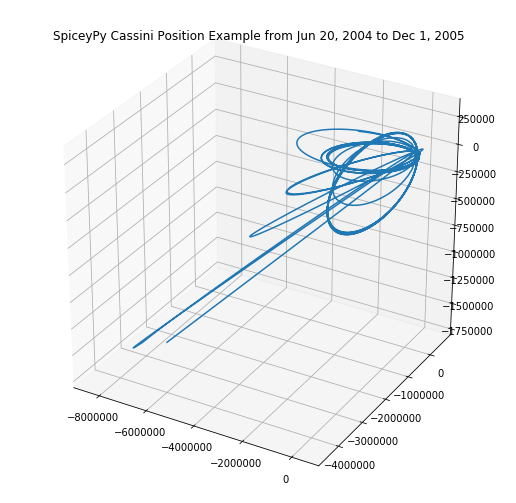

In [28]:
positions = np.asarray(positions).T # positions is a list, make it an ndarray for easier indexing
fig = plt.figure(figsize=(9, 9))
ax  = fig.add_subplot(111, projection='3d')
ax.plot(positions[0], positions[1], positions[2])
plt.title('SpiceyPy Cassini Position Example from Jun 20, 2004 to Dec 1, 2005')
plt.show()